Restarted aspire (Python 3.8.18)

In [1]:
from aspire.source.relion import RelionSource
from aspire.volume import Volume
from covar_distributed import trainParallel
from aspire.noise import WhiteNoiseEstimator,AnisotropicNoiseEstimator
from covar_sgd import CovarDataset,Covar
from covar_distributed import trainParallel
from aspire.basis import FFBBasis3D
from aspire.reconstruction import MeanEstimator
import numpy as np
L = 65
pixel_size = 2.82 * 130/ L
source = RelionSource('data/validate_preprocess/all_images_norm_preprocessed.star',pixel_size=pixel_size)

mean_vol = Volume.load(f'data/paper_dataset/mean_vol_est_L{L}.mrc')
vol_state1 = Volume.load(f'data/paper_dataset/vol_state1_est_L{L}.mrc')
vol_state2 = Volume.load(f'data/paper_dataset/vol_state2_est_L{L}.mrc')


2024-06-06 13:26:25,415 INFO [matplotlib.font_manager] Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
2024-06-06 13:26:25,465 INFO [matplotlib.font_manager] generated new fontManager
2024-06-06 13:26:28,048 INFO [aspire.source.relion] Creating ImageSource from STAR file at path data/validate_preprocess/all_images_norm_preprocessed.star
2024-06-06 13:26:28,050 INFO [aspire.storage.starfile] Parsing star file at: data/validate_preprocess/all_images_norm_preprocessed.star
2024-06-06 13:26:28,306 INFO [aspire.storage.starfile] Created StarFile with blocks: optics, particles
2024-06-06 13:26:28,516 INFO [aspire.source.image] Creating RelionSource with 10000 images.
2024-06-06 13:26:28,530 INFO [aspire.source.relion] Populated 7 CTFFilters from 'data/validate_preprocess/all_images_norm_preprocessed.star'
2024-06-06 13:26:28,546 INFO [aspire.volume.volume] data/paper_dataset/mean_vol

In [ ]:
#Ctfs before whitening
from aspire.image import Image
ctfs = np.array([f.evaluate_grid(L) for f in source.unique_filters])
Image(np.sum(np.abs(ctfs),axis=0)).show()

In [2]:
#aiso_noise_estimator = AnisotropicNoiseEstimator(source)
#source = source.whiten(aiso_noise_estimator)
from aspire.operators import ArrayFilter
import scipy

psd_est = scipy.io.loadmat('data/validate_preprocess/psd.mat')['psd']
noise_filter = ArrayFilter(psd_est)
source = source.whiten(noise_filter)

2024-06-06 13:26:32,800 INFO [aspire.source.image] Whitening source object


2024-06-06 13:26:32,802 INFO [aspire.source.image] Transforming all CTF Filters into Multiplicative Filters
2024-06-06 13:26:32,803 INFO [aspire.source.image] Adding Whitening Filter Xform to end of generation pipeline


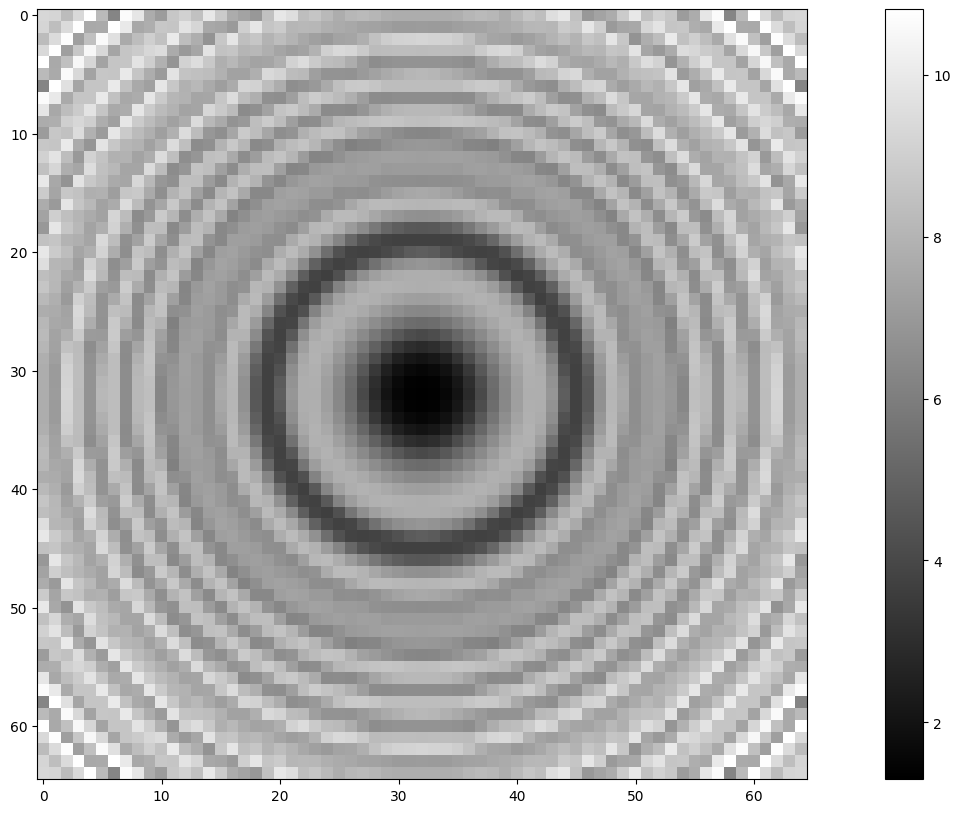

In [25]:
#Ctfs after whitening
from aspire.image import Image
ctfs = np.array([f.evaluate_grid(L) for f in source.unique_filters])
Image(np.sum(np.abs(ctfs),axis=0)).show()

In [4]:
import starfile
import re
star = starfile.read('data/validate_preprocess/all_images_norm_preprocessed.star')

mrcs_id_parser = lambda name : int(re.match(r'(\d+)@',name).group(1))
mrcs_id = star['particles']['rlnImageName'].apply(mrcs_id_parser)

star1 = star.copy()
#star1['particles'] = star1['particles'].loc[0:5000-1]
star1['particles'] = star1['particles'].iloc[np.where(mrcs_id <= 5000)[0]]
starfile.write(star1,'data/validate_preprocess/half1_images_norm_preprocessed.star')
star2 = star.copy()
#star2['particles'] = star2['particles'].loc[5000:10000]
star2['particles'] = star2['particles'].iloc[np.where(mrcs_id > 5000)[0]]
starfile.write(star2,'data/validate_preprocess/half2_images_norm_preprocessed.star')

In [ ]:
basis = FFBBasis3D((L,L,L))
mean_estimator = MeanEstimator(source,basis)
mean_vol = mean_estimator.estimate()


src1 = RelionSource('data/validate_preprocess/half1_images_norm_preprocessed.star',pixel_size=pixel_size)
vol_estimator = MeanEstimator(src1,basis)
vol_state1 = vol_estimator.estimate()
src2 = RelionSource('data/validate_preprocess/half2_images_norm_preprocessed.star',pixel_size=pixel_size)
vol_estimator = MeanEstimator(src2,basis)
vol_state2 = vol_estimator.estimate()


mean_vol.save(f'data/paper_dataset/mean_vol_est_L{L}.mrc',overwrite = True)
vol_state1.save(f'data/paper_dataset/vol_state1_est_L{L}.mrc',overwrite = True)
vol_state2.save(f'data/paper_dataset/vol_state2_est_L{L}.mrc',overwrite = True)

In [5]:
noise_estimator = WhiteNoiseEstimator(source, batchSize=500)
noise_variance = noise_estimator.estimate()

rank = 1

dataset = CovarDataset(source,noise_variance,vectorsGD=(vol_state1-vol_state2).asnumpy(),mean_volume=mean_vol)


2024-06-06 13:27:15,039 INFO [aspire.noise.noise] Determining Noise variance in batches of 500


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]

2024-06-06 13:27:22,029 INFO [aspire.noise.noise] Noise variance = 1.0058176088195756


2024-06-06 13:27:26,511 INFO [aspire.nufft.cufinufft] Converting cufinufft gpu_method=1 from default of 2 for 3D1 transform,to support computation in double precision with tol=1e-08.


In [ ]:
from aspire.image import Image
from aspire.noise import WhiteNoiseEstimator,AnisotropicNoiseEstimator

aiso_noise_estimator = AnisotropicNoiseEstimator(source)
Image(aiso_noise_estimator.filter.evaluate_grid(L)).show()

In [17]:
%load_ext autoreload
%autoreload 2
import torch
from covar_sgd import *
#cov = Covar(source.L,rank,vectors=torch.tensor((vol_state1-vol_state2).asnumpy())/2)
cov = Covar(source.L,rank)
trainParallel(cov,dataset,savepath = 'data/paper_dataset/covar_results.bin',
                batch_size = 32,
                max_epochs = 5,
                #lr = 1e-3*2,                momentum = 0.95,
                #lr = 5e-4, momentum = 0.9,
                #optim_type = 'SGD',
                lr = 1e-2,optim_type = 'Adam',
                reg = 1e-6*10,
                gamma_lr = 0.8,
                gamma_reg = 0.8,
                orthogonal_projection= False
            )
eigen_est = torch.load('data/paper_dataset/covar_results.bin')['vectors']
Volume(-eigen_est.cpu().detach().numpy()).save('data/paper_dataset/eigen_est.mrc',overwrite = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Epoch 0 , cost value : 1.12e+00,  cosine sim : 0.17, frobenium norm error : 1.01e+00: 100%|██████████| 313/313 [00:09<00:00, 32.12it/s]
Epoch 1 , cost value : 1.02e+00,  cosine sim : 0.23, frobenium norm error : 1.05e+00: 100%|██████████| 313/313 [00:09<00:00, 34.13it/s]
Epoch 2 , cost value : 1.16e+00,  cosine sim : 0.23, frobenium norm error : 1.10e+00: 100%|██████████| 313/313 [00:09<00:00, 33.86it/s]
Epoch 3 , cost value : 1.13e+00,  cosine sim : 0.23, frobenium norm error : 1.16e+00: 100%|██████████| 313/313 [00:09<00:00, 33.71it/s]
Epoch 4 , cost value : 1.17e+00,  cosine sim : 0.23, frobenium norm error : 1.21e+00: 100%|██████████| 313/313 [00:09<00:00, 34.32it/s]


In [ ]:
from aspire.covariance import CovarianceEstimator
from aspire.utils import eigs
from aspire.basis import FBBasis3D

basis = FBBasis3D((L,L,L))
covar_estimator = CovarianceEstimator(source,basis,mean_kernel=mean_estimator.kernel)
covar_est_orig = covar_estimator.estimate(mean_vol,noise_variance)
eigs_est_orig,lambdas_est_orig = eigs(covar_est_orig,5)


2024-06-06 13:37:46,132 INFO [aspire.nufft.cufinufft] Converting cufinufft gpu_method=1 from default of 2 for 3D1 transform,to support computation in double precision with tol=1e-08.
2024-06-06 13:37:55,213 INFO [aspire.nufft.cufinufft] Converting cufinufft gpu_method=1 from default of 2 for 3D1 transform,to support computation in double precision with tol=1e-08.


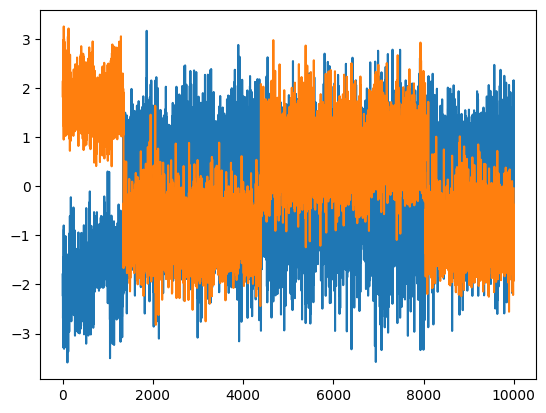

In [18]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from aspire.volume import Volume

eigen = Volume(eigen_est.cpu().detach().numpy())
projected_eigen = source.vol_forward(eigen,0,source.n)
coeffs1 = torch.sum((torch.tensor(projected_eigen.asnumpy())*dataset.images),dim=(1,2))/(torch.norm(torch.tensor(projected_eigen.asnumpy()),dim=(1,2)))**2
#coeffs1 = torch.sum((torch.tensor(projected_eigen.asnumpy())*dataset.images),dim=(1,2))/((torch.norm(torch.tensor(projected_eigen.asnumpy()),dim=(1,2)))**2+noise_variance)
plt.plot(coeffs1)

eigenGD = (vol_state1-vol_state2)/2
projected_eigenGD = source.vol_forward(eigenGD,0,source.n)
coeffs2 = torch.sum((torch.tensor(projected_eigenGD.asnumpy())*dataset.images),dim=(1,2))/(torch.norm(torch.tensor(projected_eigenGD.asnumpy()),dim=(1,2)))**2
#coeffs2 = torch.sum((torch.tensor(projected_eigenGD.asnumpy())*dataset.images),dim=(1,2))/((torch.norm(torch.tensor(projected_eigenGD.asnumpy()),dim=(1,2)))**2+noise_variance)
plt.plot(coeffs2)

plt.show()

(array([  97.,  688., 1371., 2234., 1943., 1422., 1172.,  611.,  391.,
          71.]),
 array([0.23305878, 0.2645423 , 0.29602581, 0.32750932, 0.35899283,
        0.39047635, 0.42195986, 0.45344337, 0.48492688, 0.5164104 ,
        0.54789391]),
 <BarContainer object of 10 artists>)

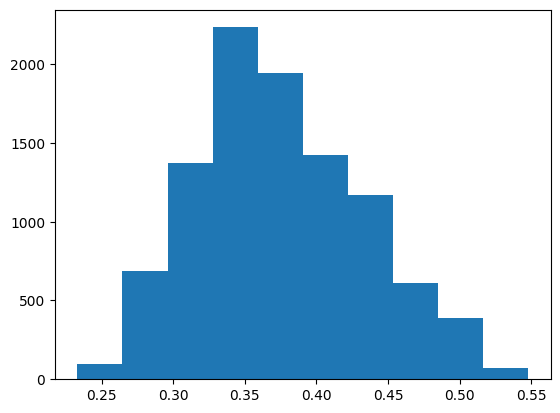

In [8]:
t = np.sum(projected_eigen * projected_eigenGD,axis=(1,2))/(np.linalg.norm(projected_eigen,axis=(1,2)) * np.linalg.norm(projected_eigenGD,axis=(1,2)))
plt.hist(t)
#np.sum(eigen * eigenGD,axis=(1,2,3))/(np.linalg.norm(eigen.asnumpy().reshape((1,-1)))*np.linalg.norm(eigenGD.asnumpy().reshape((1,-1))))



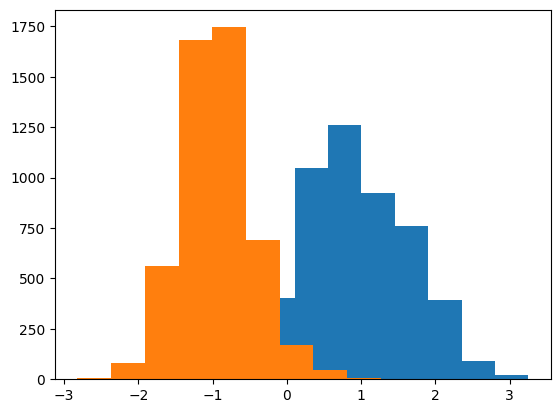

In [9]:
plt.hist(coeffs2[mrcs_id <= 5000])
plt.hist(coeffs2[mrcs_id > 5000])
plt.show()

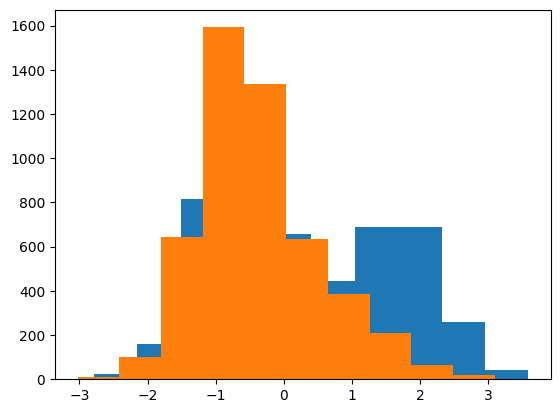

In [10]:
plt.hist(coeffs1[mrcs_id <= 5000])
plt.hist(coeffs1[mrcs_id > 5000])
plt.show()

In [ ]:
from aspire.denoising import src_wiener_coords
eigenNorm = np.linalg.norm(eigenGD.asnumpy().reshape((1,-1)))
coords_est = src_wiener_coords(source, mean_vol, eigenGD/eigenNorm, eigenNorm**2 * np.ones((1,1)), noise_variance)

from scipy.cluster.vq import kmeans2
centers, vol_idx = kmeans2(coeffs2, 2)
ref_classification = np.zeros(vol_idx.shape)
ref_classification[0:source.n//2]=1

plt.hist(coeffs2[vol_idx==1])
plt.hist(coeffs2[vol_idx==0])
plt.show()

In [ ]:
from aspire.denoising import src_wiener_coords

_,a,b = torch.linalg.svd(eigen_est.reshape((eigen_est.shape[0],-1)),full_matrices=False)
b = Volume(b.cpu().detach().numpy().reshape((3,L,L,L)))
a = a.cpu().detach().numpy()
coords_est = src_wiener_coords(source, mean_vol, b, np.diag(a)**2, noise_variance)


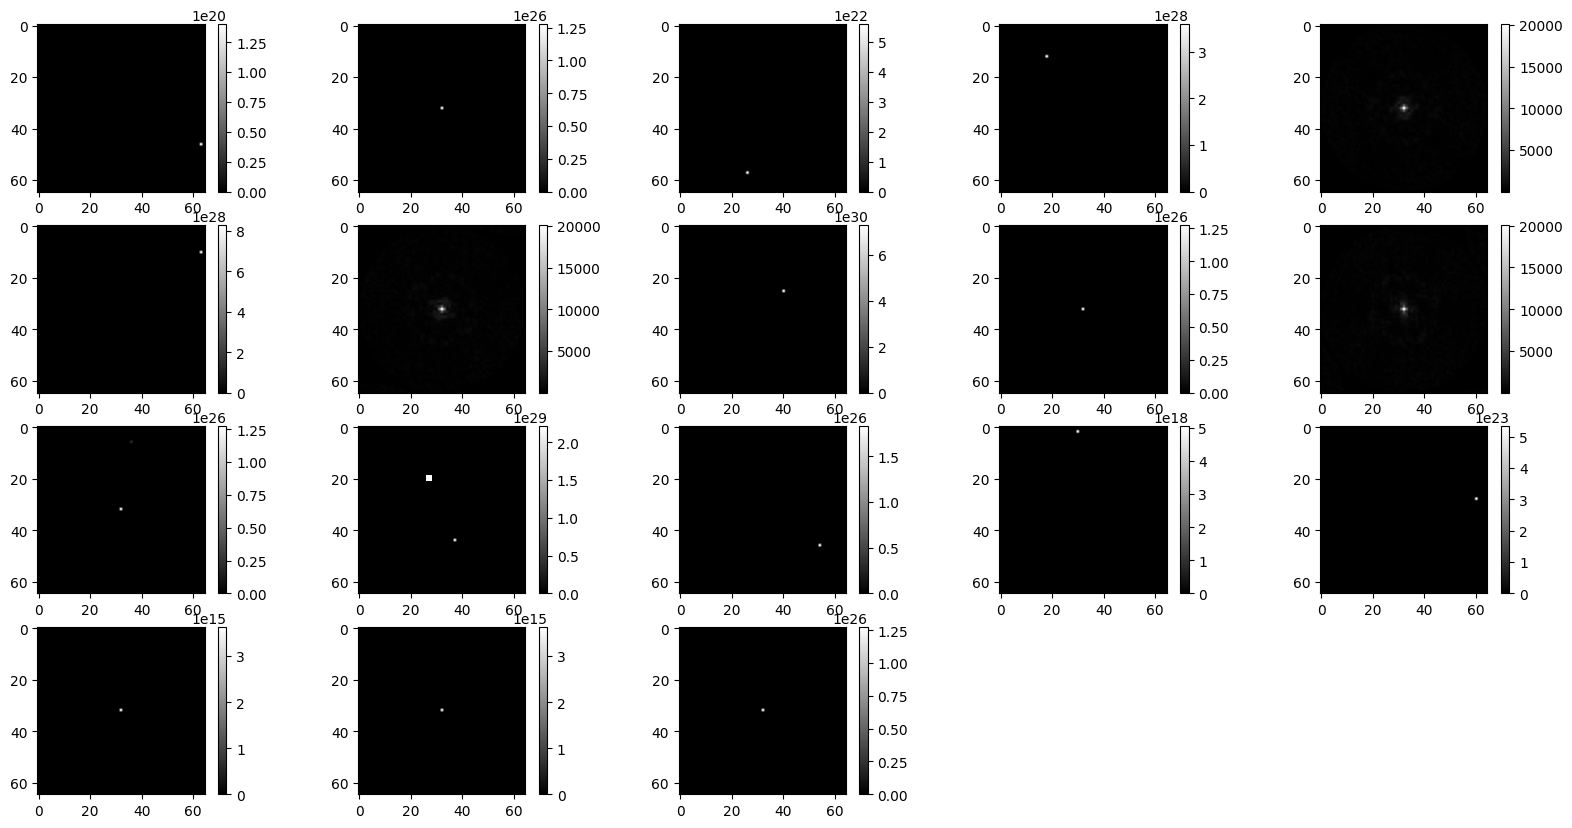

(tensor(nan, device='cuda:0'), [175, 1589, 2452, 3095, 3118, 3711, 3924, 4454, 5341, 5490, 5934, 6112, 6167, 7629, 8067, 8177, 9416, 9896])
tensor(nan, device='cuda:0')


In [40]:
from covar_sgd import evalCovarEigs
#c = evalCovarEigs(dataset,eigen_est,1)
c = evalCovarEigs(dataset,torch.tensor(eigenGD.asnumpy()).to('cuda:0'),1)
#cGD = evalCovarEigs(dataset,torch.tensor((vol_state1-vol_state2).asnumpy()/2).to('cuda:0'))
#ctest = evalCovarEigs(dataset,torch.tensor((vol_state1-vol_state2).asnumpy()/2).to('cuda:0'))

print(c)
print(cGD)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Epoch 0 , cost value : 1.12e+00,  cosine sim : 0.07, frobenium norm error : 1.00e+00: 100%|██████████| 157/157 [00:05<00:00, 30.94it/s]
Epoch 1 , cost value : 1.12e+00,  cosine sim : 0.15, frobenium norm error : 1.01e+00: 100%|██████████| 157/157 [00:04<00:00, 32.80it/s]
Epoch 2 , cost value : 1.13e+00,  cosine sim : 0.18, frobenium norm error : 1.06e+00: 100%|██████████| 157/157 [00:04<00:00, 33.29it/s]
Epoch 3 , cost value : 1.03e+00,  cosine sim : 0.19, frobenium norm error : 1.18e+00: 100%|██████████| 157/157 [00:04<00:00, 33.40it/s]
Epoch 4 , cost value : 1.02e+00,  cosine sim : 0.18, frobenium norm error : 1.30e+00: 100%|██████████| 157/157 [00:04<00:00, 33.19it/s]
Epoch 0 , cost value : 1.15e+00,  cosine sim : 0.08, frobenium norm error : 1.00e+00: 100%|██████████| 157/157 [00:05<00:00, 31.12it/s]
Epoch 1 , cost value : 1.11e+00,  cosine sim : 0.15, frobenium norm error : 1.01e+00: 100%|██████████| 157/157 [00:04<00:00, 33.67it/s]
Epoch 2 , cost value : 1.06e+00,  cosine sim : 0

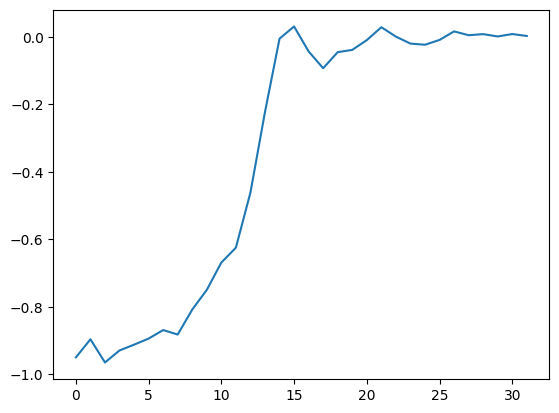

In [11]:
#Fourier shell correlation
%load_ext autoreload
%autoreload 2
import torch
from covar_sgd import *
cov = Covar(source.L,rank)
ds = dataset.get_subset(list(range(0, len(dataset), 2)))
trainParallel(cov,ds,savepath = 'data/paper_dataset/covar_results.bin',
                batch_size = 32,
                max_epochs = 5,
                #lr = 1e-3*2,                momentum = 0.95,
                #lr = 5e-4, momentum = 0.9,
                #optim_type = 'SGD',
                lr = 1e-2,optim_type = 'Adam',
                reg = 1e-6*10,
                gamma_lr = 0.8,
                gamma_reg = 0.8,
                orthogonal_projection= False
            )
eigen_est1 = torch.load('data/paper_dataset/covar_results.bin')['vectors']
Volume(-eigen_est.cpu().detach().numpy()).save('data/paper_dataset/eigen_est.mrc',overwrite = True)

cov = Covar(source.L,rank)
ds = dataset.get_subset(list(range(1, len(dataset), 2)))
trainParallel(cov,ds,savepath = 'data/paper_dataset/covar_results.bin',
                batch_size = 32,
                max_epochs = 5,
                #lr = 1e-3*2,                momentum = 0.95,
                #lr = 5e-4, momentum = 0.9,
                #optim_type = 'SGD',
                lr = 1e-2,optim_type = 'Adam',
                reg = 1e-6*10,
                gamma_lr = 0.8,
                gamma_reg = 0.8,
                orthogonal_projection= False
            )
eigen_est2 = torch.load('data/paper_dataset/covar_results.bin')['vectors']
Volume(-eigen_est.cpu().detach().numpy()).save('data/paper_dataset/eigen_est.mrc',overwrite = True)

fsc = Volume(eigen_est1.cpu().detach().numpy()).fsc(Volume(eigen_est2.cpu().detach().numpy()))
plt.plot(fsc[1].T)


In [ ]:
from aspire.source.relion import RelionStarFile

classification3Dstar = RelionStarFile('/scratch/yoelsh/hetero/relion/Class3D/job038/run_it100_data.star');
relion_classification = classification3Dstar.blocks['particles']['_rlnClassNumber']
class1_ref = np.where((relion_classification==2))
class2_ref = np.where(relion_classification==4)
class_ref = np.zeros((10000))
class_ref[class2_ref] = 1
plt.plot(class_ref[8500:])
np.sum(class_ref[8500:])